# Logistic Regression - Tuning


## Import Library

In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data (processed)

In [16]:
df = pd.read_csv('../../data/processed/df_model.csv')

X = df.drop(columns=['TARGET'])
y = df['TARGET']


## Train / Validation 

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Imputation + Scaling

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_val_imp = imputer.transform(X_val)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled = scaler.transform(X_val_imp)


## Logistic Regression with **Class Weight**

In [19]:
logreg_bal = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

logreg_bal.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

## ROC-AUC

In [20]:
y_val_proba_bal = logreg_bal.predict_proba(X_val_scaled)[:, 1]

roc_auc = roc_auc_score(y_val, y_val_proba_bal)
roc_auc

0.7462918700385168

## ROC Curve

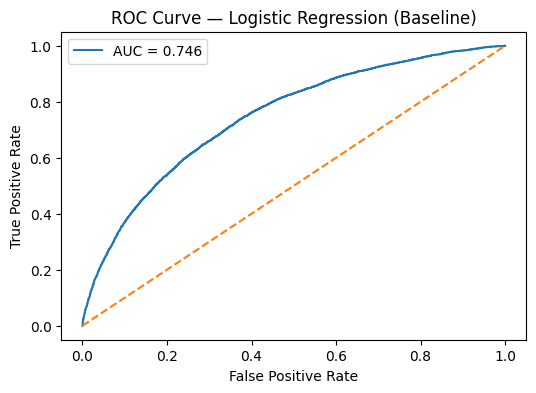

In [21]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba_bal)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (Baseline)')
plt.legend()
plt.show()


## Treshold Analysis

In [22]:
thresholds = np.arange(0.05, 0.55, 0.05)

results = []

for t in thresholds:
    y_pred_t = (y_val_proba_bal >= t).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t).ravel()
    
    results.append({
        'threshold': t,
        'recall_default': tp / (tp + fn),
        'precision_default': tp / (tp + fp) if tp + fp > 0 else 0,
        'approval_rate': (y_pred_t == 0).mean()
    })

threshold_df = pd.DataFrame(results)
threshold_df

,threshold,recall_default,precision_default,approval_rate
0,0.05,0.999597,0.080891,0.002423
1,0.10,0.997583,0.082205,0.020340
2,0.15,0.988922,0.085601,0.067379
3,0.20,0.973212,0.090842,0.135148
4,0.25,0.946022,0.097634,0.217794
5,0.30,0.913595,0.106900,0.310082
6,0.35,0.868278,0.117858,0.405265
7,0.40,0.817724,0.130930,0.495813
8,0.45,0.749849,0.144678,0.581598
9,0.50,0.670493,0.159572,0.660797


## Trade-off Visualization

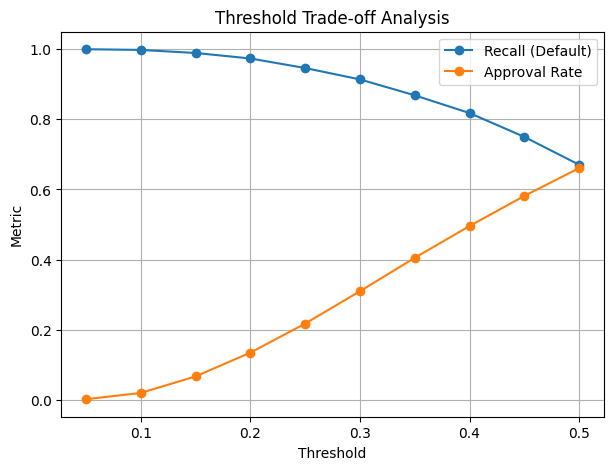

In [23]:
plt.figure(figsize=(7,5))
plt.plot(threshold_df['threshold'], threshold_df['recall_default'], marker='o', label='Recall (Default)')
plt.plot(threshold_df['threshold'], threshold_df['approval_rate'], marker='o', label='Approval Rate')

plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Threshold Trade-off Analysis')
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix at Selected Treshold

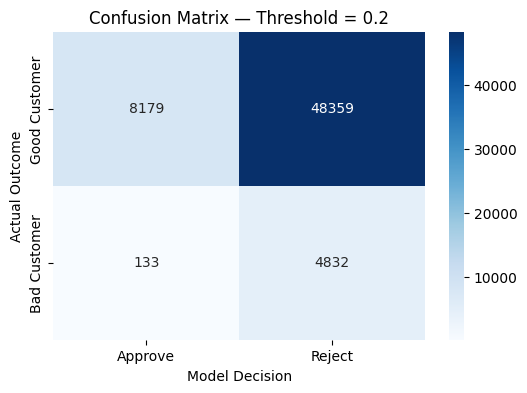

In [24]:
selected_threshold = 0.2

y_pred_sel = (y_val_proba_bal >= selected_threshold).astype(int)

cm = confusion_matrix(y_val, y_pred_sel)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Approve', 'Reject'],
    yticklabels=['Good Customer', 'Bad Customer']
)
plt.title(f'Confusion Matrix — Threshold = {selected_threshold}')
plt.xlabel('Model Decision')
plt.ylabel('Actual Outcome')
plt.show()

## Classification Report 

In [25]:
print(classification_report(y_val, y_pred_sel))

              precision    recall  f1-score   support

           0       0.98      0.14      0.25     56538
           1       0.09      0.97      0.17      4965

    accuracy                           0.21     61503
   macro avg       0.54      0.56      0.21     61503
weighted avg       0.91      0.21      0.25     61503



## Final Summary :
### Logistic Regression — Tuning Summary

Penerapan class weighting dan penyesuaian threshold meningkatkan kemampuan model dalam mendeteksi nasabah berisiko secara signifikan. 
Trade-off antara tingkat persetujuan dan risiko gagal bayar dianalisis untuk menentukan threshold yang optimal dari perspektif bisnis.

### Conclusion
Logistic Regression dengan class weighting dan threshold tuning mampu menggeser fokus model dari sekadar akurasi menjadi alat pengambilan keputusan bisnis yang fleksibel, dengan trade-off yang dapat disesuaikan sesuai risk appetite perusahaan.